In [1]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=ab6ae6d98cd762a76e6db5f5ef7d35c1533d7f9c87a63e6fc89fe3d5941eaf28
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE import lhs

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc

import sys
import os

import scipy.io
from scipy.interpolate import griddata

np.random.seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
%cd /content/drive/MyDrive/CursoPINN-CEIA-UBA/Modulo3

/content/drive/MyDrive/CursoPINN-CEIA-UBA/Modulo3


# Burger's equation

The governing equations are:
$$u_t + uu_x - \nu u_{xx} = 0$$
$$u(0,x)=-\sin(\pi x)$$
$$u(-1, t)=u(1,t)=0$$

In [5]:
 # Neural Network
class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.Viscosity = model_parameters["Viscosity"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)


    def forward(self, x):
        lb = self.LowerBounds
        ub = self.UpperBounds
        x = 2*(x - lb)/(ub - lb) - 1
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def governingEquationResidue(self, X, u):
        nu = self.Viscosity

        # Compute the derivatives of the output w.r.t. the inputs (space and time) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_x, u_t = diff_u[:, 0:1], diff_u[:, 1:2]

        # Compute the second derivative of the output w.r.t. space using AD mechanism:
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u))[0][:, 0:1]

        residue = u_t + u*u_x - nu*u_xx
        return residue

## Problem data

In [6]:
# Load data from .mat file
data = scipy.io.loadmat('./burgers_shock.mat')

t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

## Exact solution

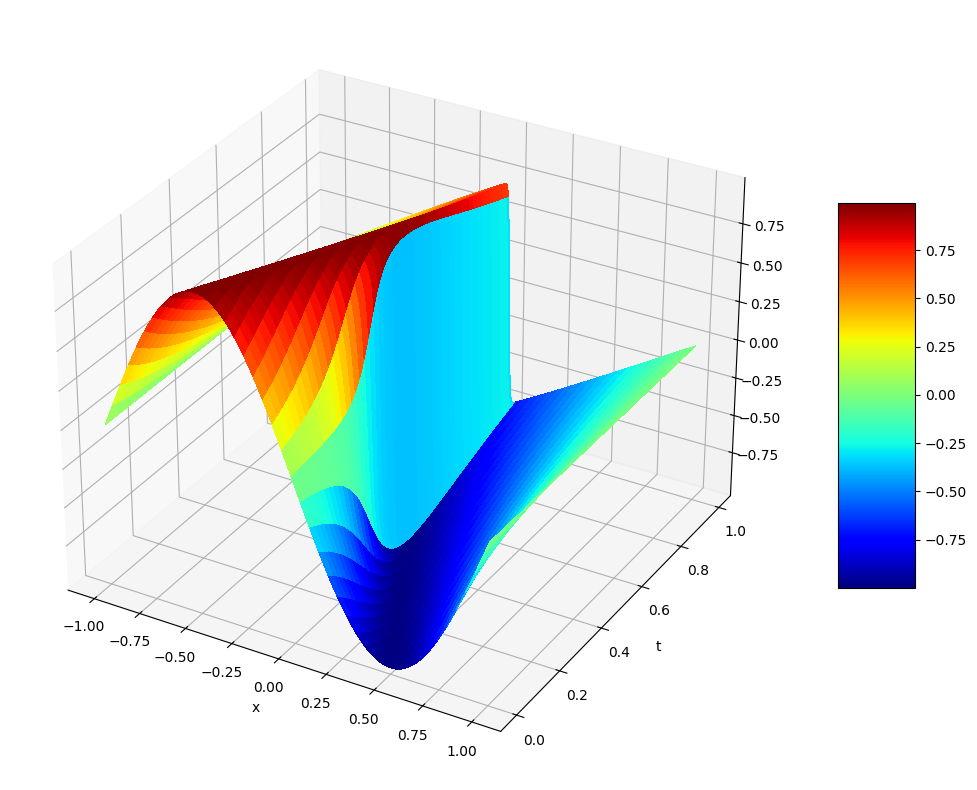

In [7]:
# Plot the exact solution
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection = '3d')
#ax.view_init(elev=20, azim=-90)
surf1 = ax.plot_surface(X, T, Exact, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf1, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('t')
plt.show()

## Datasets (collocation points and labelled data points)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx, :]
        target = self.y[idx, :]
        return features, target

In [9]:
# Domain bounds
lb = torch.from_numpy(X_star.min(0)).to(torch.float32)
ub = torch.from_numpy(X_star.max(0)).to(torch.float32)

# Initial Condition
xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
uu1 = Exact[0:1, :].T

# Boundary condition -1
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))
uu2 = Exact[:, 0:1]

# Boundary condition 1
xx3 = np.hstack((X[:, -1:], T[:, -1:]))
uu3 = Exact[:, -1:]

X_u_train = np.vstack([xx1, xx2, xx3])
u_train = np.vstack([uu1, uu2, uu3])

In [10]:
# Number of collocation points
N_dom = 10000 # Number of collocation points for evaluating the residuals
N_data = 100 # Number of labelled data points

# Train, validation and testing sets
tags = ["Domain"] #, "BoundaryConditions", "InitialCondition"]
isData = True # Flag to indicate whether the analysis would use labelled data or not

# Initialize list of dataset objects
ds = []

# Generate collocation points within the domain using Latin Hypercube Sampling (LHS) strategy
X_dom = (lb + (ub - lb)*lhs(2, N_dom)).to(torch.float32)
y_dom = torch.zeros((N_dom, 1), device=device)

# Generate random collocation points for the left boundary
X_bc_l = torch.from_numpy(xx2).to(torch.float32)
y_bc_l = torch.zeros((len(xx2), 1), device=device)

# Generate random collocation points for the right boundary
X_bc_r = torch.from_numpy(xx3).to(torch.float32)
y_bc_r = torch.zeros((len(xx3), 1), device=device)

# Generate collocation points for the initial condition
X_ic = torch.from_numpy(xx1).to(torch.float32)
y_ic = torch.zeros((len(xx1), 1), device=device)

# Concatente X_dom with other datasets
X_dom = torch.cat([X_dom, X_bc_l, X_bc_r, X_ic], axis=0)
y_dom = torch.cat([y_dom, y_bc_l, y_bc_r, y_ic], axis=0)
ds.append(CustomDataset(X_dom, y_dom))

# Generate syntetic temperature labelled data
if isData:
    tags.append("LabelledData")
    idx = np.random.choice(X_u_train.shape[0], N_data, replace=False)
    X_data = torch.from_numpy(X_u_train[idx, :]).to(torch.float32)
    y_data = torch.from_numpy(u_train[idx, :]).to(torch.float32)
    ds.append(CustomDataset(X_data, y_data))

# Dictionary of dataset objects
datasets = dict(zip(tags, ds))

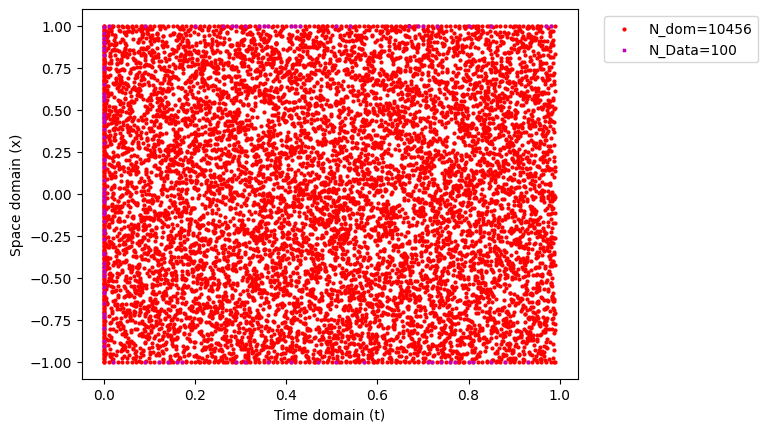

In [11]:
# Plot the locations of the collocation points in the space-time domain
X_dom_train = (datasets["Domain"].X).data.cpu().numpy()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_dom_train[:, 1:2], X_dom_train[0:, 0:1], s=4, c='r', label=f'N_dom={len(X_dom_train)}')
if isData:
    X_data_train = (datasets["LabelledData"].X).data.cpu().numpy()
    y_data_train = (datasets["LabelledData"].y).data.cpu().numpy()
    ax.scatter(X_data_train[:, 1:2], X_data_train[:, 0:1], s=4, c='m', label=f'N_Data={len(X_data_train)}', marker='x')
ax.legend()
plt.xlabel('Time domain (t)')
plt.ylabel('Space domain (x)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

## Main execution

In [12]:
# Input dictionary for model instance
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "Viscosity": 0.01/np.pi, #0.001, # (N.s.m^-2)
    "InputDimensions": 2,
    "OutputDimensions": 1,
    "NumberOfNeurons": 20,
    "NumberOfHiddenLayers": 8,
    "ActivationFunction": nn.Tanh()
}

In [13]:
def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            torch.nn.init.uniform_(m.bias, 0, 1)

    model.apply(init_weights)

In [14]:
# Model construction
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)
init_xavier(model)

In [15]:
# Definition of weights for the SA strategy
N_dom_tot = X_dom.size()[0]
N_weights = N_dom_tot + X_data.size()[0]
weights = torch.ones((N_weights, 1), requires_grad=True, device=device)
#weights.requires_grad = True
mask = lambda x: x #torch.exp(x)

In [16]:
# Fitting stage
t0 = datetime.now()
data_time_now = datetime.now().strftime("%d%m%Y_%H%M%S")

# Initialization of data structures
epochs = 1000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer_weights = torch.optim.Adam([weights], lr=1e-3)
loss_train = []
loss_train_dom = []
loss_train_data = []
train_keys = ['Overall', 'Domain', 'Data']

# Training loop
for epoch in range(epochs):
    loss_list = []
    for tag in tags:
        X = (datasets[tag].X).to(device)
        y = (datasets[tag].y).to(device)
        if tag=='Domain':
            X.requires_grad = True
            u = model(X)
            y_hat = model.governingEquationResidue(X, u)
            loss = (mask(weights[:N_dom_tot, :])*(y_hat - y)**2).mean() #loss_fn(y_hat, y)
            loss_list.append(loss)

        else:
            u = model(X)
            loss = (mask(weights[N_dom_tot:, :])*(u - y)**2).mean() #loss_fn(u, y)
            loss_list.append(loss)

    # Minimize loss w.r.t. model parameters
    loss = sum(loss_list)
    optimizer.zero_grad(set_to_none=True)
    loss.backward() #retain_graph=True
    optimizer.step()

    # Compute again the loss (not efficient, but throws an error. See comment below)
    loss_list2 = []
    for tag in tags:
        X = (datasets[tag].X).to(device)
        y = (datasets[tag].y).to(device)
        if tag=='Domain':
            X.requires_grad = True
            u = model(X)
            y_hat = model.governingEquationResidue(X, u)
            loss = (mask(weights[:N_dom_tot, :])*(y_hat - y)**2).mean() #loss_fn(y_hat, y)
            loss_list2.append(loss)

        else:
            u = model(X)
            loss = (mask(weights[N_dom_tot:, :])*(u - y)**2).mean() #loss_fn(u, y)
            loss_list2.append(loss)

    # Maximize loss w.r.t. weights
    loss = sum(loss_list2)
    optimizer_weights.zero_grad(set_to_none=True)
    (-loss).backward()
    optimizer_weights.step()

    # Display losses
    loss_list.insert(0, loss)
    loss_train.append(loss_list[0].item())
    loss_train_dom.append(loss_list[1].item())
    if isData:
        loss_train_data.append(loss_list[2].item())

    if epoch % 100 == 0:
        log_dict = dict(zip(train_keys, loss_list))
        aux = "".join(f"{key}: {value:.5e}, " for key, value in log_dict.items())
        optimizer_str = type(optimizer).__name__
        print(f"##TRAIN## {optimizer_str} - Epoch: {epoch}, " + aux)


elapsed_time_train = datetime.now() - t0
print("\nTraining Time: ", elapsed_time_train.seconds, "[s]")

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


##TRAIN## Adam - Epoch: 0, Overall: 3.05050e-01, Domain: 3.23108e-03, Data: 3.52224e-01, 
##TRAIN## Adam - Epoch: 100, Overall: 2.08915e-01, Domain: 1.03818e-02, Data: 2.00161e-01, 
##TRAIN## Adam - Epoch: 200, Overall: 9.66495e-02, Domain: 2.73437e-02, Data: 6.98448e-02, 
##TRAIN## Adam - Epoch: 300, Overall: 7.28811e-02, Domain: 1.96081e-02, Data: 5.35247e-02, 
##TRAIN## Adam - Epoch: 400, Overall: 6.51292e-02, Domain: 1.54571e-02, Data: 4.97511e-02, 
##TRAIN## Adam - Epoch: 500, Overall: 5.75489e-02, Domain: 1.55248e-02, Data: 4.35982e-02, 
##TRAIN## Adam - Epoch: 600, Overall: 3.70335e-02, Domain: 1.16010e-02, Data: 2.55666e-02, 
##TRAIN## Adam - Epoch: 700, Overall: 2.07622e-02, Domain: 7.64461e-03, Data: 1.26536e-02, 
##TRAIN## Adam - Epoch: 800, Overall: 1.12064e-02, Domain: 6.20379e-03, Data: 3.79534e-03, 
##TRAIN## Adam - Epoch: 900, Overall: 4.67374e-03, Domain: 3.15504e-03, Data: 1.65332e-03, 

Training Time:  28 [s]


From ChatGPT:

The error "RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation" occurs because the PyTorch computation graph is retained across updates to parameters (including weights1 and weights2). When we try to backpropagate a second time using the same graph, PyTorch detects that one of the parameters was modified in-place, which interferes with the saved gradients.

To fix this issue, we can avoid reusing the same computation graph by separating the loss computations for the model and weights updates. Specifically, we can:

Compute the loss and perform the backward pass for the model parameters.
Recompute the loss for the weights after updating the model parameters (instead of retaining the original computation graph).

## Loss functions

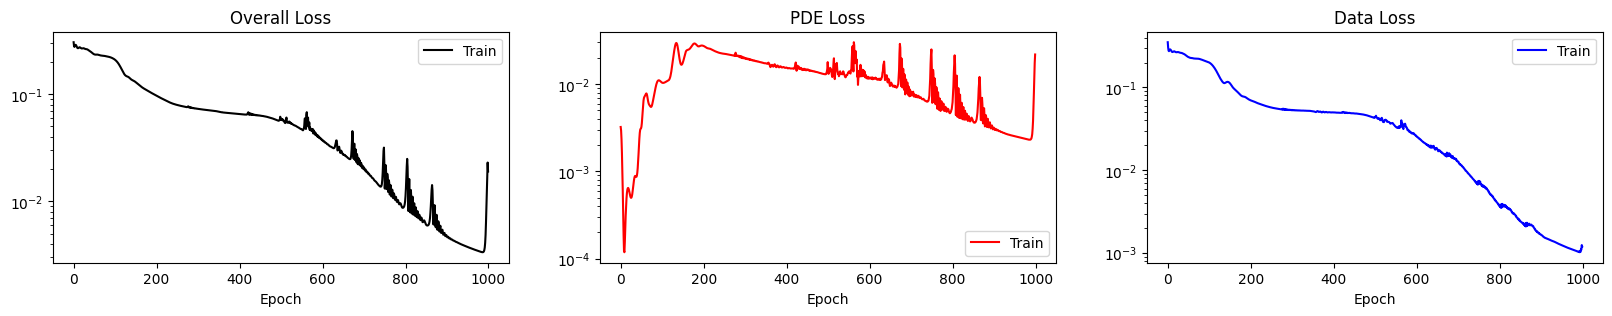

In [17]:
# Evolution of the loss function
loss_train_list = [loss_train, loss_train_dom] #, loss_train_bc, loss_train_ic]
colors = ['black', 'red', 'blue', 'green']
titles = ['Overall Loss', 'PDE Loss'] #, 'BC Loss', 'IC Loss']
if isData:
    loss_train_list.append(loss_train_data)
    colors.append('magenta')
    titles.append('Data Loss')

fig, ax = plt.subplots(1, len(loss_train_list), figsize=(20, 3))
for i in range(len(loss_train_list)):
    epochs_train = np.arange(0, len(loss_train_list[i]))
    ax[i].semilogy(epochs_train, loss_train_list[i], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()

## Prediction

In [18]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

In [19]:
X_pred = torch.from_numpy(X_star).to(torch.float).to(device)
u_pred = model(X_pred).data.cpu().numpy()
X, T = np.meshgrid(x, t)

#X_star_tensor = tf.convert_to_tensor(X_star, dtype=tf.float32)
#u_pred = predict(X_star_tensor)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = 100* np.linalg.norm(Exact - U_pred) / np.linalg.norm(U_pred)

Error u: 7.101917e-02


Text(0.5, 1.0, '$t = 0.75$')

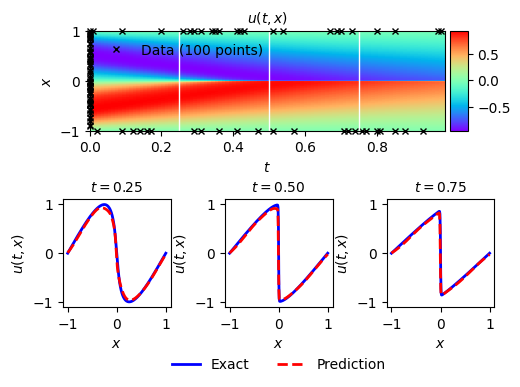

In [20]:
fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_data[:,1], X_data[:,0], 'kx', label = 'Data (%d points)' % (y_data.shape[0]), markersize = 4, clip_on = False)
#ax.plot(X_f_train[0:100,1], X_f_train[0:100,0], 'bx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.75$', fontsize = 10)

## Weights

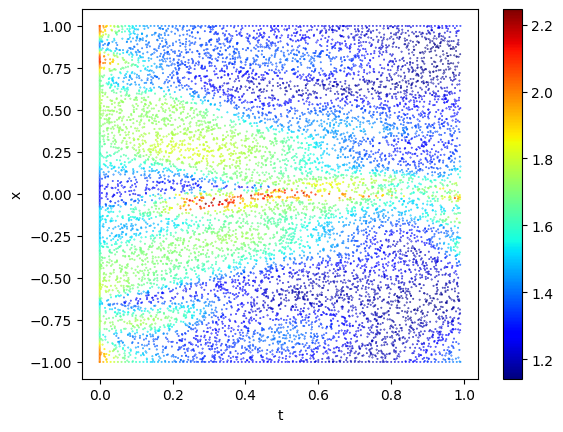

In [21]:
x_aux = X_dom.data.cpu().numpy()
w_aux = mask(weights[:N_dom_tot])
fig = plt.figure()
ax = fig.add_subplot(111)
sc = ax.scatter(x_aux[:, 1:2], x_aux[:, 0:1], c=w_aux.data.cpu().numpy(), s=w_aux.data.cpu().numpy()/10, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.axis('scaled')
plt.colorbar(sc)
ax.set_aspect('auto')
plt.show()